In [1]:
# Author: Morpheus Hsieh
# Ref: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from __future__ import print_function, division  

import os, sys
import copy
import matplotlib.pyplot as plt
import numpy as np
import shutil
import time
import zipfile


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

plt.ion()   # interactive mode

In [2]:
def decompressImages(procPath, zipAbspath):
    with zipfile.ZipFile(zipAbspath, 'r') as zip_ref:
        zip_ref.extractall(procPath)
        data_path = os.path.join(procPath, 'hymenoptera_data')
        
        list_dir = os.listdir(data_path)
        for sub_dir in list_dir:
            move_path = os.path.join(data_path, sub_dir)
            print(move_path)
            shutil.move(move_path, ProcPath)
        shutil.rmtree(data_path)
    return


ProcPath = r'D:\GitWork\ants_and_bees\processed'

RawPath  = r'D:\GitWork\ants_and_bees\raw'
RawFname = 'hymenoptera_data.zip'
ZipAbspath = os.path.join(RawPath, RawFname)

isExist = os.path.exists(ProcPath)
print('{} exist? {}'.format(ProcPath, isExist))
if not isExist: 
    decompressImages(ProcPath, ZipAbspath)
        

D:\GitWork\ants_and_bees\processed exist? True


In [3]:
ProcessedPath = r'D:\GitWork\ants_and_bees\processed'

normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std  = [0.229, 0.224, 0.225]
)

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(ProcessedPath, x), data_transforms[x])
    for x in ['train', 'valid']
}

trainSet = image_datasets['train']
validSet = image_datasets['valid']

class_names = trainSet.classes
print('classes: ', class_names)

class_indexes = trainSet.class_to_idx
print('class to index: ', class_indexes)

print()
print('size: ', len(trainSet))

trainX, trainY = trainSet[0]
print('\nimage:')
print(trainX)
print('label:', trainY)

classes:  ['ants', 'bees']
class to index:  {'ants': 0, 'bees': 1}

size:  244

image:
tensor([[[-0.7650, -0.7479, -0.7650,  ..., -0.6965, -0.6965, -0.6965],
         [-0.7479, -0.7308, -0.7650,  ..., -0.6965, -0.6794, -0.6794],
         [-0.7479, -0.7650, -0.7822,  ..., -0.7137, -0.7137, -0.6965],
         ...,
         [-0.6452, -0.6623, -0.6281,  ..., -0.6109, -0.6281, -0.6452],
         [-0.6281, -0.6281, -0.6109,  ..., -0.6109, -0.6281, -0.6452],
         [-0.6452, -0.6452, -0.6281,  ..., -0.6452, -0.6281, -0.6109]],

        [[ 0.5903,  0.6078,  0.5903,  ...,  0.6604,  0.6604,  0.6604],
         [ 0.6078,  0.6254,  0.5903,  ...,  0.6604,  0.6779,  0.6779],
         [ 0.6078,  0.5903,  0.5728,  ...,  0.6429,  0.6429,  0.6604],
         ...,
         [ 0.8004,  0.7829,  0.7829,  ...,  0.7479,  0.7304,  0.7129],
         [ 0.8179,  0.8179,  0.7829,  ...,  0.7479,  0.7304,  0.7129],
         [ 0.8004,  0.8004,  0.7829,  ...,  0.7129,  0.7304,  0.7479]],

        [[ 2.2391,  2.2566,  

In [4]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    ) for x in ['train', 'valid']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
print(dataset_sizes)

show_size = 10
for i, data in enumerate(image_datasets['train']):
    if i >= show_size: break
    print('\ni:',i)
    image, label = data
    print('image:', image)
    print('label:', label)


{'train': 244, 'valid': 153}

i: 0
image: tensor([[[-0.6794, -0.6794, -0.6794,  ..., -0.7479, -0.7822, -0.7650],
         [-0.6794, -0.6965, -0.6965,  ..., -0.7479, -0.7650, -0.7993],
         [-0.6794, -0.6965, -0.7137,  ..., -0.7308, -0.7822, -0.7822],
         ...,
         [-0.6452, -0.6452, -0.6623,  ..., -1.4158, -2.0323, -2.0494],
         [-0.6452, -0.6452, -0.6452,  ..., -2.0837, -2.1008, -2.1008],
         [-0.6452, -0.6452, -0.6281,  ..., -1.5357, -1.5185, -1.5185]],

        [[ 0.6254,  0.5903,  0.5903,  ...,  0.5728,  0.5728,  0.5903],
         [ 0.6254,  0.6254,  0.6254,  ...,  0.5728,  0.5903,  0.5553],
         [ 0.6254,  0.6429,  0.6429,  ...,  0.5728,  0.5728,  0.5728],
         ...,
         [ 0.7479,  0.7479,  0.7304,  ..., -1.3354, -1.9657, -1.9657],
         [ 0.7479,  0.7479,  0.7479,  ..., -2.0007, -2.0007, -2.0182],
         [ 0.7479,  0.7479,  0.7654,  ..., -1.0378, -1.0028, -1.0203]],

        [[ 2.2914,  2.2914,  2.3088,  ...,  2.2217,  2.2217,  2.2391],
   

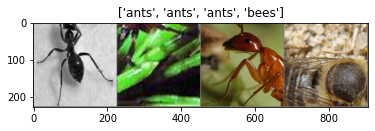

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
print(inputs.shape)
# print(inputs)
print(classes)

torch.Size([4, 3, 224, 224])
tensor([0, 0, 0, 1])


In [7]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")
print(device)

cuda:0


In [8]:
# Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Finetuning the convnet

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
# Train and evaluate

model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.5874 Acc: 0.7049
valid Loss: 0.2049 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.3623 Acc: 0.8443
valid Loss: 0.1484 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4961 Acc: 0.7992
valid Loss: 0.4224 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.4631 Acc: 0.8484
valid Loss: 0.2743 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.5159 Acc: 0.8156
valid Loss: 0.2858 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.4739 Acc: 0.8279
valid Loss: 0.3054 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.5225 Acc: 0.8074
valid Loss: 0.3384 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3405 Acc: 0.8730
valid Loss: 0.2844 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3739 Acc: 0.8279
valid Loss: 0.2188 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2812 Acc: 0.8934
valid Loss: 0.2630 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2543 Acc: 0.9016
valid Loss: 0.2489 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2843 Acc: 0.8811
valid Loss

In [11]:
# Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

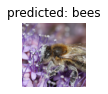

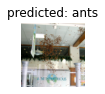

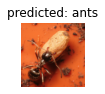

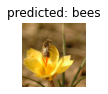

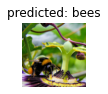

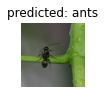

In [12]:
visualize_model(model_ft)